We will build the same Linear model and neural network for Titanic problem, but now using fastai along with Pytorch. Some cons:

- Best practices are handled for you automatically.
- Less time getting set up, which means more time to try out your new ideas.
- You can always drop down from fastai to PyTorch if you need to customise any part.

In [1]:
import pandas as pd
from fastai.tabular.all import (
    accuracy,
    tabular_learner,
    set_seed,
    slide,
    valley,
    Categorify,
    CategoryBlock,
    FillMissing,
    Normalize,
    TabularPandas
)


pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [2]:
import os


import numpy as np

### Prep the data

In [3]:
import os

datasets_base_path = "../../../../datasets"
trainset_path = os.path.join(datasets_base_path, "titanic_train.csv")

df = pd.read_csv(trainset_path)

df.shape

(891, 12)

In [4]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(
        dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG")
    )
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

In [5]:
add_features(df)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,True,1,Mr


We can use RandomSplitter to separate out the training and validation sets:

In [6]:
from fastai.data.transforms import RandomSplitter


splits = RandomSplitter(seed=42)(df)

In [7]:
# The entire process of getting the data ready for training requires just this one cell!:



dls = TabularPandas(
    df,
    splits=splits, # indices for training and validation sets
    procs = [Categorify, FillMissing, Normalize], # processing to od
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"], # categorical independent vars
    # continuous independent variables
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", # dependent variable
    # The dependent variable is categorical (so build a classification model, not a regression one)
    y_block = CategoryBlock(),
).dataloaders(path=".")

### Train the model

The data and model together make up a Learner

In [8]:
learner = tabular_learner(dls, metrics=accuracy, layers=[10,10])
learner

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

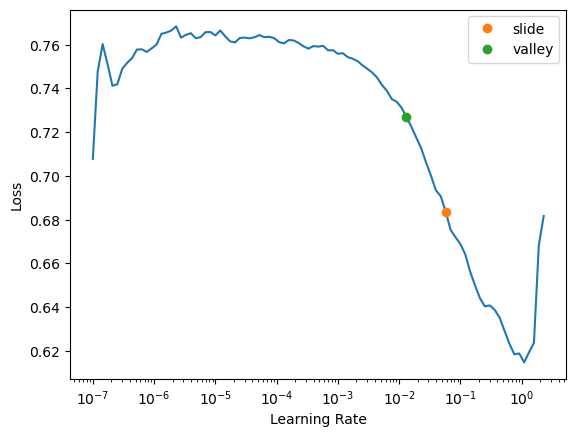

In [9]:
# One handy feature that fastai can also tell us what learning rate to use:

learner.lr_find(suggest_funcs=(slide, valley))

In [10]:
NUM_EPOCHS = 16
LEARNING_RATE = 0.1

learner.fit(NUM_EPOCHS, lr=0.03)


### Test

In [11]:
testset_path = os.path.join(datasets_base_path, "titanic_test.csv")

tst_df = pd.read_csv(testset_path)
tst_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,NaN,S


In [12]:
# perform the same preprocessing
tst_df["Fare"] = tst_df.Fare.fillna(0)
add_features(tst_df)

We don't need to manually specify any of the processing steps necessary to get the data ready for modeling, since that's all saved in the learner.

In [13]:
tst_dl = learner.dls.test_dl(tst_df)

tst_dl

In [14]:
# predictions

preds,_ = learner.get_preds(dl=tst_dl)

preds[:5]

tensor([[0.8755, 0.1245],
        [0.8073, 0.1927],
        [0.9635, 0.0365],
        [0.9113, 0.0887],
        [0.3139, 0.6861]])

In [15]:
(preds[:,1]>0.5).int()

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

### Ensembling

We can create 5 separate models, each trained from different random starting points, and average them. This is the simplest approach of ensembling models, which combines multiple models to generate predictions that are better than any of the single models in the ensemble.

In [16]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [18]:
all_preds = [ensemble() for _ in range(5)]

In [19]:
import torch

# We stack this predictions together and take their average predictions:
ens_preds = torch.stack(all_preds).mean(0)


In [20]:
(ens_preds[:,1]>0.5).int()

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,